# Coherence Analyses of Microseismic Events

The notebook makes a comparison of the eigenvalue decay of coherence matrix in the case of the existence of microsiesmic events vs when there is no coherent event. Specifically, we look at three cases:
1. When there is no coherent event
2. When there is a small coherent event
3. When there is a big coherent event

Coherence here is defined by Welch method for two signals, x and y as
$$Coherence(x,y) = \frac{E[P_{xy}]^2}{E[P_{xx}]E[P_{yy}]}$$

where $P_{xy}$ is the cross power spectral density of x and y, $P_{xx}$ is the power spectral density of x and $P_{yy}$ is the power spectral density of y.

In our custom function, we represent the the computation of coherence matrix as a the squared absolute of the product of a matrix and its conjugate transpose, $U$. The columns of $U$ corresponding to a discrete frequency of the fourier transform in continuous time windows. Then the coherence matrix is computed as
$$C = |U^*U|^2$$

`normalised_windowed_spectra` computes $U$ and `welch_coherence_matrix` computes $C$ but does the normalization as the last step and does not explicitly compute $U$.

### Make imports and write functions

In [46]:
import scipy.signal as ss
import h5py
from IPython.display import HTML, display
import numpy as np
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from scipy.fft import ifft
from sklearn.utils.extmath import randomized_svd

In [47]:
def loadBradyHShdf5(file, normalize="yes"):
    """

    Parameters
    ----------
    file : str
        path to brady hotspring h5py data file
    normalize : str, optional
        "yes" or "no". Indicates whether or not to remove laser drift and
        normalize. The default is 'yes'.

    Returns
    -------
    data : np array
        channel by samples numpy array of data
    timestamp_arr : numpy array
        array of the timestamps corresponding to the various samples in the
        data. Timestamps for brady hotspring data are with respect to the
        beginning time of the survey.

    """
    with h5py.File(file, "r") as open_file:
        dataset = open_file["das"]
        time = open_file["t"]
        data = np.array(dataset)
        timestamp_arr = np.array(time)
    data = np.transpose(data)
    if normalize == "yes":
        nSamples = np.shape(data)[1]
        # get rid of laser drift
        med = np.median(data, axis=0)
        for i in range(nSamples):
            data[:, i] = data[:, i] - med[i]

        max_of_rows = abs(data[:, :]).sum(axis=1)
        data = data / max_of_rows[:, np.newaxis]
    return data, timestamp_arr


def windowed_spectra(
    data: np.array, subwindow_len: int, overlap, freq=None, sample_interval=1
):
    """
    Calculate the frequency domain representation of data in windows.
    """
    win_start = 0
    window_samples = int(subwindow_len / sample_interval)
    total_samples = data.shape[-1]
    overlap = int(overlap / sample_interval)
    intervals = np.arange(
        window_samples, total_samples + 1, window_samples, dtype=int
    )  # break time series into windowed intervals

    win_end = intervals[0]

    absolute_spectra = np.fft.rfft(data[:, win_start:win_end])
    win_spectra = absolute_spectra[np.newaxis]

    while win_end < total_samples:
        win_start = win_end - overlap
        win_end = win_start + window_samples

        absolute_spectra = np.fft.rfft(data[:, win_start:win_end])
        win_spectra = np.append(
            win_spectra, absolute_spectra[np.newaxis], axis=0
        )
        # win_start = win_end

    frequencies = np.fft.rfftfreq(window_samples, sample_interval)

    return win_spectra, frequencies


def welch_coherence(
    data: np.array, subwindow_len: int, overlap, freq=None, sample_interval=1
):
    """
    Calculate the coherence matrix at all (or particular frequencies: yet to be implemented)
    using the welch method.
    """
    win_spectra, frequencies = windowed_spectra(
        data, subwindow_len, overlap, freq, sample_interval
    )

    normalizer = np.sum(np.absolute(win_spectra) ** 2, axis=0)
    normalizer = np.tile(normalizer, (normalizer.shape[0], 1, 1))
    normalizer = normalizer * normalizer.transpose((1, 0, 2))
    normalizer = normalizer.transpose(2, 1, 0)

    welch_numerator = np.matmul(
        win_spectra.transpose(2, 1, 0),
        np.conjugate(win_spectra.transpose(2, 0, 1)),
    )
    welch_numerator = np.absolute(welch_numerator) ** 2
    coherence = np.multiply(welch_numerator, 1 / normalizer)

    return coherence, frequencies


def normalised_windowed_spectra(
    data: np.array, subwindow_len: int, overlap, freq=None, sample_interval=1
):
    win_spectra, frequencies = windowed_spectra(
        data, subwindow_len, overlap, freq, sample_interval
    )

    normalizer = np.sum(np.absolute(win_spectra) ** 2, axis=0)
    normalizer = np.tile(normalizer, (win_spectra.shape[0], 1, 1))
    normalizer = normalizer.transpose(2, 1, 0)

    normalized_spectra = win_spectra.transpose(2, 1, 0) / normalizer

    return normalized_spectra, frequencies

The above functions were not doing the right thing. The new functions below are more accurate. I am keeping the old functions to track my mistakes.

In [48]:
def windowed_spectra(
    data: np.array, subwindow_len: int, overlap, freq=None, sample_interval=1
):
    """
    Calculate the frequency domain representation of data in windows.
    """
    win_start = 0
    window_samples = int(subwindow_len / sample_interval)
    total_samples = data.shape[-1]
    overlap = int(overlap / sample_interval)
    intervals = np.arange(
        window_samples, total_samples + 1, window_samples, dtype=int
    )  # break time series into windowed intervals

    win_end = intervals[0]

    absolute_spectra = np.fft.rfft(data[:, win_start:win_end])
    win_spectra = absolute_spectra[np.newaxis]

    while win_end < total_samples:
        win_start = win_end - overlap
        win_end = win_start + window_samples
        absolute_spectra = np.fft.rfft(data[:, win_start:win_end])
        win_spectra = np.append(
            win_spectra, absolute_spectra[np.newaxis], axis=0
        )
        # win_start = win_end

    frequencies = np.fft.rfftfreq(window_samples, sample_interval)

    return win_spectra, frequencies


def normalised_windowed_spectra(
    data: np.array, subwindow_len: int, overlap, freq=None, sample_interval=1
):
    """
    Calculate the frequency domain representation of data in windows.
    """
    win_spectra, frequencies = windowed_spectra(
        data, subwindow_len, overlap, freq, sample_interval
    )

    normalizer = np.sum(np.absolute(win_spectra) ** 2, axis=0)
    normalizer = np.tile(np.sqrt(normalizer), (win_spectra.shape[0], 1, 1))
    normalizer = normalizer.transpose(2, 1, 0)

    normalized_spectra = win_spectra.transpose(2, 1, 0) / normalizer

    return normalized_spectra, frequencies


def welch_coherence(
    data: np.array, subwindow_len: int, overlap, freq=None, sample_interval=1
):
    """
    Calculate the coherence matrix at all (or particular frequencies: yet to be implemented)
    using the welch method.
    """
    win_spectra, frequencies = windowed_spectra(
        data, subwindow_len, overlap, freq, sample_interval
    )

    normalizer = np.sum(np.absolute(win_spectra) ** 2, axis=0)
    # normalizer = np.tile(np.sqrt(normalizer), (win_spectra.shape[0], 1, 1))

    normalizer = np.tile(normalizer, (normalizer.shape[0], 1, 1))
    normalizer = normalizer * normalizer.transpose((1, 0, 2))
    normalizer = normalizer.transpose(2, 1, 0)

    # seems to give a slight speedup
    # normalized_spectra = win_spectra.transpose(2, 1, 0) / normalizer
    # coherence = np.matmul(normalized_spectra, np.conjugate(normalized_spectra.transpose(0,2,1)))
    # coherence = np.absolute(coherence)**2

    welch_numerator = np.matmul(
        win_spectra.transpose(2, 1, 0),
        np.conjugate(win_spectra.transpose(2, 0, 1)),
    )
    welch_numerator = np.absolute(welch_numerator) ** 2
    coherence = np.multiply(welch_numerator, 1 / normalizer)

    return coherence, frequencies

### Parameters for data and tests

In [80]:
fsize = 15

samples_per_sec = 1000
win_len = 2.5
overlap = 0

# subwin_width = 4096 # number of samples in each subwindow
# num_subwins = 10 # number of subwindows to average over
# avgwin_width = num_subwins * subwin_width # number of samples in averaging window

# start_ch = 1000
# nchannels = 3000

start_ch = 3100
nchannels = 2000
# nchannels = 5100

# start_ch = 10
# nchannels = 3000

# start_ch = 5500
# nchannels = 2500

# start_ch = 100
# nchannels = 5000

# Background noise test

In [50]:
file = r"D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160312000018.h5"
data_noise, _ = loadBradyHShdf5(file, normalize="no")

file = r"D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160312000048.h5"
data_noise2, _ = loadBradyHShdf5(file, normalize="no")

data_noise = np.append(data_noise, data_noise2, axis=1)

C:\Users\issah\AppData\Local\Temp\ipykernel_13912\1079790332.py:26: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  data=np.array(dataset)
C:\Users\issah\AppData\Local\Temp\ipykernel_13912\1079790332.py:27: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  timestamp_arr=np.array(time)


In [81]:
coherence_noise, frequencies = welch_coherence(
    data_noise[start_ch : nchannels + start_ch : int(nchannels / 200)],
    win_len,
    overlap,
    sample_interval=0.001,
)

norm_win_spectra, frequencies = normalised_windowed_spectra(
    data_noise[start_ch : nchannels + start_ch : int(nchannels / 200)],
    win_len,
    overlap,
    sample_interval=0.001,
)

Try plotting eigenvalues of coherence matrix for background noise and setting a threshold for the eigenvalues. If the eigenvalues are above the threshold, then there is a coherent event.

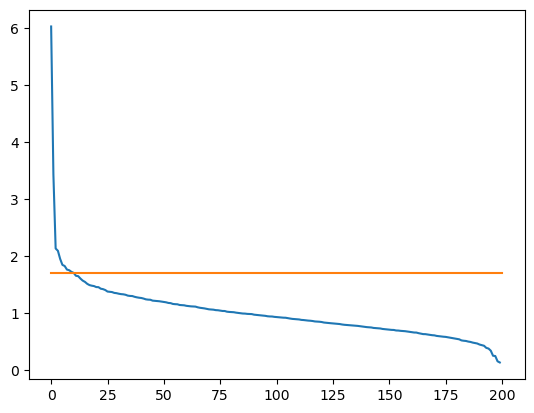

In [52]:
eigenvals, eigenvecs = np.linalg.eig(coherence_noise[50])
# plt.imshow(coherence_noise[0])
# plt.colorbar()
plt.plot(np.sort(eigenvals)[::-1])

perc95 = np.percentile(eigenvals, 95)

plt.plot([0, 200], [perc95, perc95])

eigenvals = np.sort(eigenvals)[::-1]
# np.where(eigenvals > np.percentile(eigenvals,95))

# eigenvals[0]/np.sum(eigenvals[1:])

Calculate and plot detection parameter
$$\text{Detection parameter} = \frac{\lambda_1}{\sum_{i=1}^{n}{\lambda_i}}$$
for all frequencies.

In [82]:
num_frames = coherence_noise.shape[0]

eig_ratios = np.empty(num_frames)
for d in range(num_frames):
    eigenvals, _ = np.linalg.eig(coherence_noise[d])
    eigenvals = np.sort(eigenvals)[::-1]
    eig_ratios[d] = eigenvals[0] / np.sum(eigenvals)

Text(0.5, 1.0, 'Proportion of $\\lambda_1$ in sum of all eigenvalues')

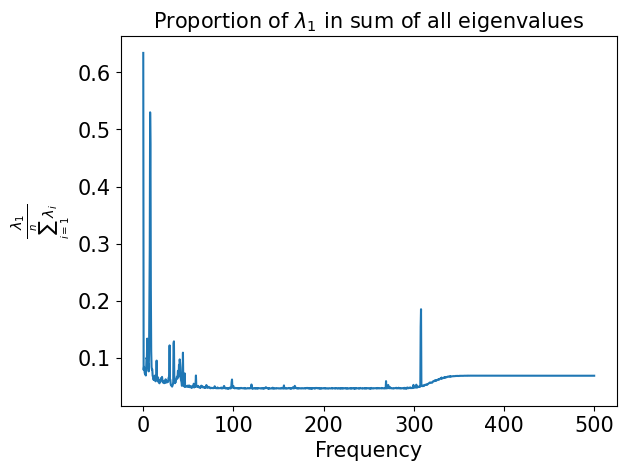

In [83]:
plt.plot(frequencies, eig_ratios)
plt.ylabel(r"$\frac{\lambda_1}{\sum_{i=1}^{n}{\lambda_i}}$", fontsize=fsize)
plt.xlabel("Frequency", fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.title(
    "Proportion of $\lambda_1$ in sum of all eigenvalues", fontsize=fsize
)

### Plot data

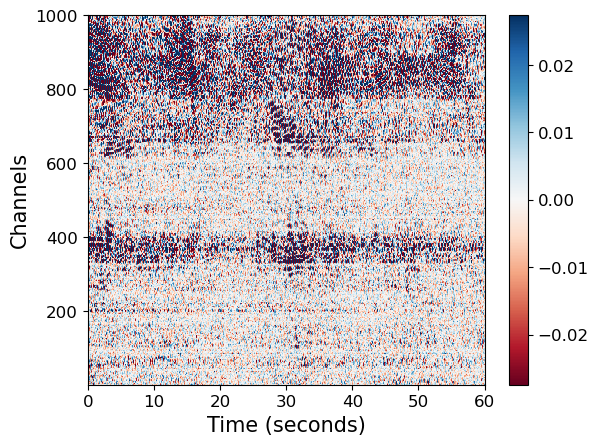

In [55]:
# pdata=np.append(data[:,24976:],data2[:,:10000],axis=1)
# pdata=data_noise
# pdata = pdata[start_ch:nchannels+start_ch]
tick_size = 12
ch_start = 1

fig2 = plt.figure()
img2 = plt.imshow(
    data_noise[start_ch : nchannels + start_ch],
    cmap="RdBu",
    vmin=-np.percentile(
        np.absolute(data_noise[start_ch : nchannels + start_ch]), 90
    ),
    vmax=np.percentile(
        np.absolute(data_noise[start_ch : nchannels + start_ch]), 90
    ),
    aspect="auto",
    interpolation="none",
    extent=(
        0,
        len(data_noise[start_ch : nchannels + start_ch][0]) / samples_per_sec,
        ch_start,
        ch_start + nchannels,
    ),
)
# extent=(mdates.date2num(np.datetime64(props['GPSTimeStamp'])),mdates.date2num(np.datetime64(props['GPSTimeStamp'])+np.timedelta64(60,'s')), distances[0],distances[-1]))
plt.xlabel("Time (seconds)", fontsize=fsize)
plt.ylabel("Channels", fontsize=fsize)
# plt.title('Background noise',fontsize=fsize)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=tick_size)

# Small event test

In [91]:
file = r"D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160314062648.h5"
data, _ = loadBradyHShdf5(file, normalize="no")

file = r"D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160314062718.h5"
data2, _ = loadBradyHShdf5(file, normalize="no")

data = np.append(data, data2, axis=1)

C:\Users\issah\AppData\Local\Temp\ipykernel_13912\1079790332.py:26: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  data=np.array(dataset)
C:\Users\issah\AppData\Local\Temp\ipykernel_13912\1079790332.py:27: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  timestamp_arr=np.array(time)


In [92]:
coherence_small_event, frequencies = welch_coherence(
    data[start_ch : nchannels + start_ch : int(nchannels / 200)],
    win_len,
    overlap,
    sample_interval=0.001,
)
# coherence_small_event, frequencies = welch_coherence(data[start_ch:nchannels+start_ch:int(nchannels/200), 25000:], win_len, overlap, sample_interval=0.001)

# norm_win_spectra_small_event, frequencies = normalised_windowed_spectra(data[start_ch:nchannels+start_ch:int(nchannels/200)], 5, 2.5, sample_interval=0.001)
norm_win_spectra_small_event, frequencies = normalised_windowed_spectra(
    data[start_ch : nchannels + start_ch : int(nchannels / 200), 20000:],
    win_len,
    overlap,
    sample_interval=0.001,
)

In [93]:
num_frames = coherence_small_event.shape[0]
eig_ratios_small_event = np.empty(num_frames)
for d in range(num_frames):
    eigenvals, _ = np.linalg.eig(coherence_small_event[d])
    eigenvals = np.sort(eigenvals)[::-1]
    eig_ratios_small_event[d] = eigenvals[0] / np.sum(eigenvals)

Text(0.5, 1.0, 'Proportion of $\\lambda_1$ in sum of all eigenvalues')

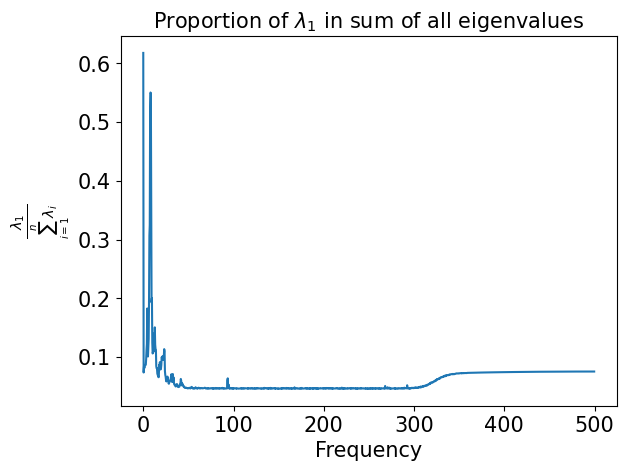

In [94]:
frequency_extent_ind = -1
plt.plot(
    frequencies[:frequency_extent_ind],
    eig_ratios_small_event[:frequency_extent_ind],
)
plt.ylabel(r"$\frac{\lambda_1}{\sum_{i=1}^{n}{\lambda_i}}$", fontsize=fsize)
plt.xlabel("Frequency", fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.title(
    "Proportion of $\lambda_1$ in sum of all eigenvalues", fontsize=fsize
)

### Plot data

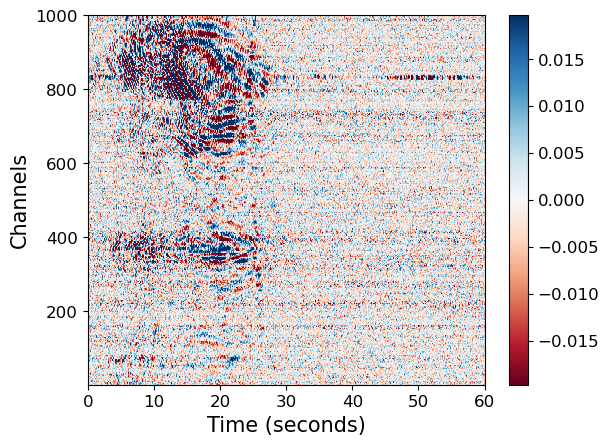

In [60]:
# pdata=np.append(data[:,24976:],data2,axis=1) #data[:,10000:] # data[:,10000:25000]
tick_size = 12
pdata = data[
    start_ch : nchannels + start_ch
]  # [start_ch:nchannels+start_ch, 25000:]
# what channel to start label on plot at
ch_start = 1  # start_channel

fig2 = plt.figure()
img2 = plt.imshow(
    pdata,
    cmap="RdBu",
    vmin=-np.percentile(np.absolute(pdata), 96),
    vmax=np.percentile(np.absolute(pdata), 96),
    aspect="auto",
    interpolation="none",
    extent=(
        0,
        len(pdata[0]) / samples_per_sec,
        ch_start,
        ch_start + nchannels,
    ),
)
# extent=(mdates.date2num(np.datetime64(props['GPSTimeStamp'])),mdates.date2num(np.datetime64(props['GPSTimeStamp'])+np.timedelta64(60,'s')), distances[0],distances[-1]))
plt.xlabel("Time (seconds)", fontsize=fsize)
plt.ylabel("Channels", fontsize=fsize)
# plt.title('Signal',fontsize=fsize)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=tick_size)

# Big event test

In [61]:
# file = r"D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160314083818.h5"
# data3,_ = loadBradyHShdf5(file,normalize='no')

file = r"D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160314083848.h5"
data, _ = loadBradyHShdf5(file, normalize="no")

file = r"D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160314083918.h5"
data2, _ = loadBradyHShdf5(file, normalize="no")

data = np.append(data, data2, axis=1)
# data = np.append(data3,data,axis=1)

C:\Users\issah\AppData\Local\Temp\ipykernel_13912\1079790332.py:26: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  data=np.array(dataset)
C:\Users\issah\AppData\Local\Temp\ipykernel_13912\1079790332.py:27: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  timestamp_arr=np.array(time)


In [87]:
coherence_big_event, frequencies = welch_coherence(
    data[start_ch : nchannels + start_ch : int(nchannels / 200)],
    win_len,
    overlap,
    sample_interval=0.001,
)

# norm_win_spectra_big_event, frequencies = normalised_windowed_spectra(data[start_ch:nchannels+start_ch:int(nchannels/200), 20000:], win_len, overlap, sample_interval=0.001)

In [88]:
num_frames = coherence_big_event.shape[0]
eig_ratios_big_event = np.empty(num_frames)
for d in range(num_frames):
    eigenvals, _ = np.linalg.eig(coherence_big_event[d])
    eigenvals = np.sort(eigenvals)[::-1]
    eig_ratios_big_event[d] = eigenvals[0] / np.sum(eigenvals)

Text(0.5, 1.0, 'Proportion of $\\lambda_1$ in sum of all eigenvalues')

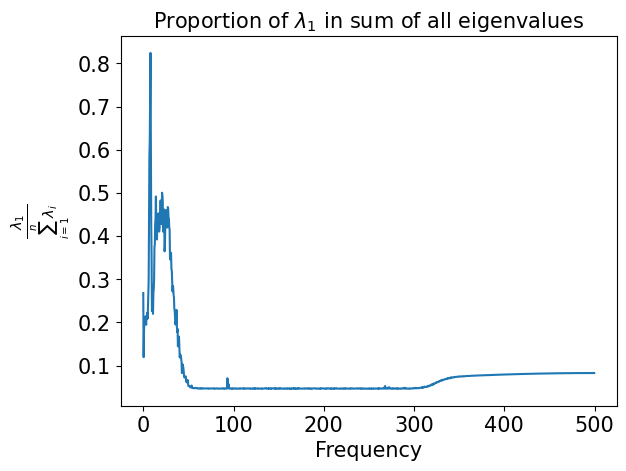

In [89]:
frequency_extent_ind = -1
plt.plot(
    frequencies[:frequency_extent_ind],
    eig_ratios_big_event[:frequency_extent_ind],
)
plt.ylabel(r"$\frac{\lambda_1}{\sum_{i=1}^{n}{\lambda_i}}$", fontsize=fsize)
plt.xlabel("Frequency", fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.title(
    "Proportion of $\lambda_1$ in sum of all eigenvalues", fontsize=fsize
)

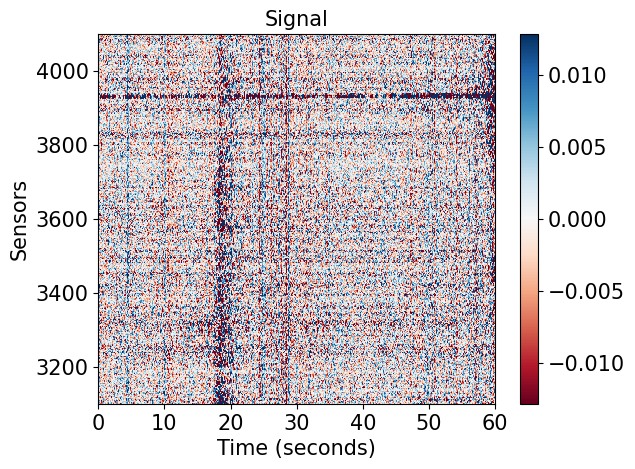

In [65]:
fig2 = plt.figure()
img2 = plt.imshow(
    data[start_ch : nchannels + start_ch],
    cmap="RdBu",
    vmin=-np.percentile(np.absolute(pdata), 90),
    vmax=np.percentile(np.absolute(pdata), 90),
    aspect="auto",
    interpolation="none",
    extent=(
        0,
        len(pdata[0]) / samples_per_sec,
        start_ch,
        start_ch + nchannels,
    ),
)
# extent=(mdates.date2num(np.datetime64(props['GPSTimeStamp'])),mdates.date2num(np.datetime64(props['GPSTimeStamp'])+np.timedelta64(60,'s')), distances[0],distances[-1]))
plt.xlabel("Time (seconds)", fontsize=fsize)
plt.ylabel("Sensors", fontsize=fsize)
plt.title("Signal", fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=fsize)

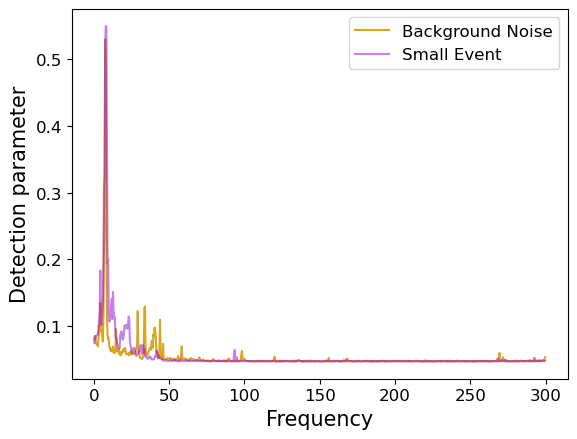

In [97]:
last_freq_index = int(len(frequencies) / 5) * 3  # -1 # 200
tick_size = 12
plt.plot(
    frequencies[1:last_freq_index],
    eig_ratios[1:last_freq_index],
    color="goldenrod",
    label="Background Noise",
)
plt.plot(
    frequencies[1:last_freq_index],
    eig_ratios_small_event[1:last_freq_index],
    color="darkviolet",
    alpha=0.5,
    label="Small Event",
)
# plt.plot(frequencies[1:last_freq_index], eig_ratios_big_event[1:last_freq_index], color="salmon", alpha=0.7 , label="Big Event")
# plt.ylabel(r"$\frac{\lambda_1}{\sum_{i=1}^{n}{\lambda_i}}$",fontsize=fsize)
plt.ylabel("Detection parameter", fontsize=fsize)
plt.xlabel("Frequency", fontsize=fsize)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
# plt.title("Proportion of $\lambda_1$ in sum of all eigenvalues",fontsize=fsize)
# plt.grid(minor=True)
plt.legend(fontsize=tick_size)

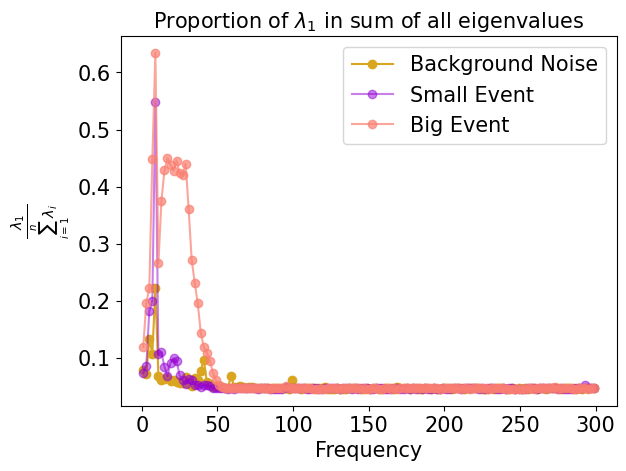

In [99]:
avg_every = 5
last_freq_index = int(len(frequencies) / 5 / avg_every) * 3  # -1 # 200

# avg_eigs = np.mean(eig_ratios[1:].reshape((int(len(eig_ratios[1:])/avg_every),avg_every)), axis=1)
# avg_eigs2 = np.mean(eig_ratios_small_event[1:].reshape((int(len(eig_ratios_small_event[1:])/avg_every),avg_every)), axis=1)
avg_freq = np.linspace(
    1,
    2 * int(len(eig_ratios_small_event[1:]) / avg_every) - 1,
    int(len(eig_ratios_small_event[1:]) / avg_every),
)

sub_eigs_noise = eig_ratios[1:].reshape(
    (int(len(eig_ratios[1:]) / avg_every), avg_every)
)[:, 0]
sub_eigs_small_event = eig_ratios_small_event[1:].reshape(
    (int(len(eig_ratios_small_event[1:]) / avg_every), avg_every)
)[:, 0]
sub_eigs_big_event = eig_ratios_big_event[1:].reshape(
    (int(len(eig_ratios_big_event[1:]) / avg_every), avg_every)
)[:, 0]

# plt.plot(avg_freq, avg_eigs)
# plt.plot(avg_freq[:last_freq_index], avg_eigs2[:last_freq_index], '-o')
# plt.plot(avg_freq[:last_freq_index], sub_eigs_small_event[:last_freq_index], '-o')

plt.plot(
    avg_freq[:last_freq_index],
    sub_eigs_noise[:last_freq_index],
    "-o",
    color="goldenrod",
    label="Background Noise",
)
plt.plot(
    avg_freq[:last_freq_index],
    sub_eigs_small_event[:last_freq_index],
    "-o",
    color="darkviolet",
    alpha=0.5,
    label="Small Event",
)
plt.plot(
    avg_freq[:last_freq_index],
    sub_eigs_big_event[:last_freq_index],
    "-o",
    color="salmon",
    alpha=0.7,
    label="Big Event",
)

plt.ylabel(r"$\frac{\lambda_1}{\sum_{i=1}^{n}{\lambda_i}}$", fontsize=fsize)
plt.xlabel("Frequency", fontsize=fsize)
plt.title(
    "Proportion of $\lambda_1$ in sum of all eigenvalues", fontsize=fsize
)
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.legend(fontsize=fsize)

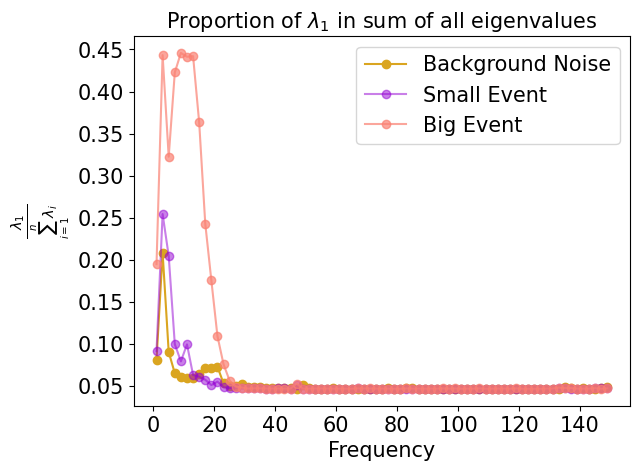

In [103]:
avg_every = 10
last_freq_index = int(len(frequencies) / 5 / avg_every) * 3  # -1 # 200

avg_freq = np.linspace(
    1,
    2 * int(len(eig_ratios_small_event[1:]) / avg_every) - 1,
    int(len(eig_ratios_small_event[1:]) / avg_every),
)

avg_eigs_noise = np.mean(
    eig_ratios[1:].reshape((int(len(eig_ratios[1:]) / avg_every), avg_every)),
    axis=1,
)
avg_eigs_small_event = np.mean(
    eig_ratios_small_event[1:].reshape(
        (int(len(eig_ratios_small_event[1:]) / avg_every), avg_every)
    ),
    axis=1,
)
avg_eigs_big_event = np.mean(
    eig_ratios_big_event[1:].reshape(
        (int(len(eig_ratios_big_event[1:]) / avg_every), avg_every)
    ),
    axis=1,
)

plt.plot(
    avg_freq[:last_freq_index],
    avg_eigs_noise[:last_freq_index],
    "-o",
    color="goldenrod",
    label="Background Noise",
)
plt.plot(
    avg_freq[:last_freq_index],
    avg_eigs_small_event[:last_freq_index],
    "-o",
    color="darkviolet",
    alpha=0.5,
    label="Small Event",
)
plt.plot(
    avg_freq[:last_freq_index],
    avg_eigs_big_event[:last_freq_index],
    "-o",
    color="salmon",
    alpha=0.7,
    label="Big Event",
)

plt.ylabel(r"$\frac{\lambda_1}{\sum_{i=1}^{n}{\lambda_i}}$", fontsize=fsize)
plt.xlabel("Frequency", fontsize=fsize)
plt.title(
    "Proportion of $\lambda_1$ in sum of all eigenvalues", fontsize=fsize
)
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.legend(fontsize=fsize)